## Use flat dT dataset to produce explanatory plots for paper

In [74]:
# System tools  
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore") # suppress warnings

# Python stack 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# Internal modules 
sys.path.extend(["../../src/core", "../../src/utils"])
from draw import Draw
from io_manager import Load

# pyutils 
from pyutils.pyplot import Plot
plotter = Plot() # just use this for styles

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


In [75]:
!ls ../../output/dt/b/data/*

../../output/dt/b/data/CE_mix2BB_onspill-LH_aw:
cut_flow.csv  events.parquet  hists.h5	results.pkl

../../output/dt/b/data/CE_onspill-LH_aw:
cut_flow.csv  events.parquet  hists.h5	results.pkl

../../output/dt/b/data/CRY_mix2BB_onspill-LH_aw:
cut_flow.csv  events.parquet  hists.h5	results.pkl

../../output/dt/b/data/CRY_onspill-LH_aw:
cut_flow.csv  events.parquet  hists.h5	results.pkl


In [76]:
run = "b"
base_in_path = Path(f"../../output/dt/{run}/data/")

# Load both test datasets
cry_path = base_in_path / "CRY_onspill-LH_aw/"
ce_mix2bb_path = base_in_path / "CE_mix2BB_onspill-LH_aw/"

print(f"Loading CRY data from: {cry_path}")
cry_data = Load(in_path=cry_path).load_pkl()["events"]

print(f"Loading CE Mix2BB data from: {ce_mix2bb_path}")
ce_mix_data = Load(in_path=ce_mix2bb_path).load_pkl()["events"]

print(f"CRY events: {len(cry_data)}")
print(f"CE mix2BB events: {len(ce_mix_data)}")

Loading CRY data from: ../../output/dt/b/data/CRY_onspill-LH_aw
[Load] ✅ Initialised with out_path=../../output/dt/b/data/CRY_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../output/dt/b/data/CRY_onspill-LH_aw/results.pkl
Loading CE Mix2BB data from: ../../output/dt/b/data/CE_mix2BB_onspill-LH_aw
[Load] ✅ Initialised with out_path=../../output/dt/b/data/CE_mix2BB_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../output/dt/b/data/CE_mix2BB_onspill-LH_aw/results.pkl
CRY events: 23727
CE mix2BB events: 2139827


In [77]:
df_cry = ak.to_dataframe(cry_data)
df_ce_mix = ak.to_dataframe(ce_mix_data)

In [78]:
# Time cut
def apply_start_end_cut(df, start_end_window=(420, 1700)):
    """"""
    start, end = start_end_window
    condition = (df["timeStart"] > start) & (df["timeEnd"] < end)
    return df[condition]

df_cry = apply_start_end_cut(df_cry)
df_ce_mix = apply_start_end_cut(df_ce_mix)

In [89]:
img_base_path = Path(f"../../output/images/dt/paper/")
img_base_path.mkdir(exist_ok=True, parents=True)

[pyplot] ✅ Wrote:
	../../output/images/dt/paper/h1o_dT_raw_cosmic_beam.png


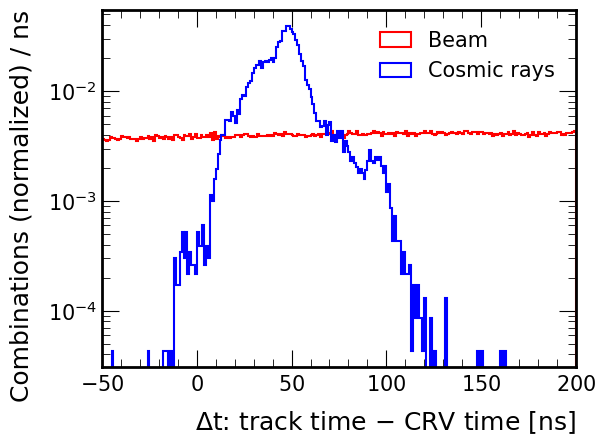

In [80]:
# Do we need the time cut here? 
# Should plot both ce and cry just so I know what's happening

plotter.plot_1D_overlay(
    {
        "Beam": df_ce_mix['dT'].values,
        "Cosmic rays" : df_cry['dT'].values,
    },
    nbins=250,
    xmin=-50,
    xmax=200,
    log_y=True,
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]",
    ylabel="Combinations (normalized) / ns",
    norm_by_area=True,
    out_path = img_base_path / "h1o_dT_raw_cosmic_beam.png" 
)


In [81]:
def apply_start_end_cut(df, start_end_window=(420, 1700)):
    """"""
    start, end = start_end_window
    condition = (df["timeStart"] > start) & (df["timeEnd"] < end)
    return df[condition]

df_cry = apply_start_end_cut(df_cry)
df_ce_mix = apply_start_end_cut(df_ce_mix)


Refined peak dT value: 48.42 ns
Wrote: ../../output/images/dt/paper/h1_dT_all_with_peak.png


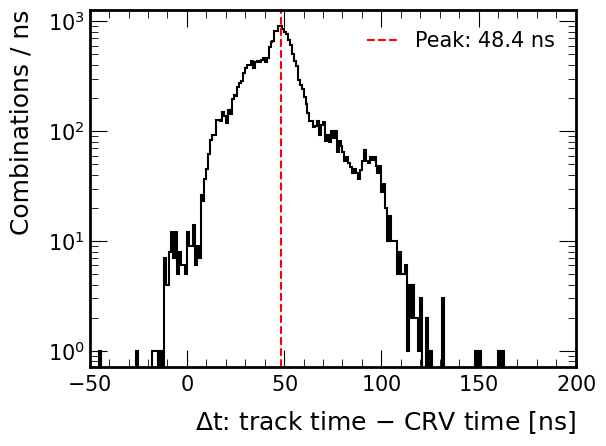

In [82]:
# Calculate the peak of the dT distribution
dT_values = df_cry['dT'].values

# Create histogram to find peak
hist, bin_edges = np.histogram(dT_values, bins=200, range=(-50, 200))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Find the peak
peak_idx = np.argmax(hist)
peak_dT = bin_centers[peak_idx]
peak_count = hist[peak_idx]

# Refine with finer binning around the peak
fine_range = (peak_dT - 10, peak_dT + 10)
fine_hist, fine_edges = np.histogram(dT_values, bins=100, range=fine_range)
fine_centers = (fine_edges[:-1] + fine_edges[1:]) / 2
fine_peak_idx = np.argmax(fine_hist)
fine_peak_dT = fine_centers[fine_peak_idx]

print(f"\nRefined peak dT value: {fine_peak_dT:.2f} ns")

fig, ax = plt.subplots() # 1, 2, figsize=(2*6.4, 4.8))

plotter.plot_1D(
    dT_values,
    nbins=250,
    xmin=-50,
    xmax=200,
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]",
    ylabel="Combinations / ns",
    ax=ax,
    show=False,
    log_y=True,
)

ax.axvline(fine_peak_dT, color='red', linestyle='--', linewidth=1.5, label=f'Peak: {fine_peak_dT:.1f} ns')
ax.legend()
plt.tight_layout()
img_base_path = Path(f"../../output/images/dt/paper/")
img_base_path.mkdir(exist_ok=True, parents=True)
out_name = img_base_path / "h1_dT_all_with_peak.png" 
fig.savefig(out_name, dpi=300)
print(f"Wrote: {out_name}")
plt.show()

In [83]:
# Now we need to show all combinations overlaid with most propable dT 

def get_prob_dT(df, name="prob_dT"):
    """
    Get the dT value closest to the peak 
    """
    # Calculate the peak of the dT distribution
    dT_values = df_cry['dT'].values

    # Create histogram to find peak
    hist, bin_edges = np.histogram(dT_values, bins=200, range=(-50, 200))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Find the peak
    peak_idx = np.argmax(hist)
    peak_dT = bin_centers[peak_idx]
    peak_count = hist[peak_idx]

    # Refine with finer binning around the peak
    fine_range = (peak_dT - 10, peak_dT + 10)
    fine_hist, fine_edges = np.histogram(dT_values, bins=100, range=fine_range)
    fine_centers = (fine_edges[:-1] + fine_edges[1:]) / 2
    fine_peak_idx = np.argmax(fine_hist)
    fine_peak_dT = fine_centers[fine_peak_idx]
    print(f"\nProbable dT value: {fine_peak_dT:.2f} ns")

    df = df.copy(deep=True)  # Avoid modifying original dataframe
    df['dist'] = np.abs(df['dT'] - fine_peak_dT)
    
    # Get the most probable dT for each event
    prob_dt_per_event = df.loc[df.groupby(['event', 'subrun'])['dist'].idxmin()][['event', 'subrun', 'dT']]
    prob_dt_per_event = prob_dt_per_event.rename(columns={'dT': 'prob_dT'})
    
    # Merge back to add as column
    df = df.merge(prob_dt_per_event, on=['event', 'subrun'], how='left')
    df = df.drop(columns=['dist'])
    
    return df
 
df_cry = get_prob_dT(df_cry, name="prob_dT")
df_ce_mix = get_prob_dT(df_ce_mix, name="prob_dT")




Probable dT value: 48.42 ns

Probable dT value: 48.42 ns


[pyplot] ✅ Wrote:
	../../output/images/dt/paper/h1o_dT_all_and_prob.png


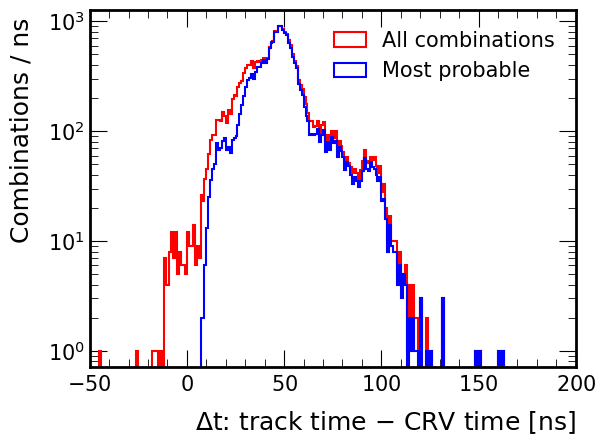

In [158]:
## Just for completeness 
# fig, ax = plt.subplots(1, 2, figsize=(2*6.4, 4.8))

# Plot both distributions
dT = df_cry['dT'].values
dt_prob = df_cry['prob_dT'].values 
# drop duplicates 
dt_prob = df_cry.drop_duplicates(subset=['event', 'subrun'])['prob_dT'].values

plotter.plot_1D_overlay(
    {
        "All combinations": dT,    
        "Most probable": dt_prob
    },
    nbins=250,
    xmin=-50,
    xmax=200,
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]",
    ylabel="Combinations / ns ",
    # ax=ax,
    show=True,
    log_y=True,
    out_path = img_base_path / "h1o_dT_all_and_prob.png" 
)


In [163]:
# Scan timing window ranges
print("Scanning timing windows...")

ax[0].set_xlim(105, 165)
ax[1].set_xlim(105, 165)
ax[0].set_ylim(-35, 12.5)
ax[1].set_ylim(-35, 12.5)


# Define ranges to scan
lower_bounds = np.arange(-35, 20, 5) 
upper_bounds = np.arange(105, 170, 5) 

results = []
for dt_min in lower_bounds:
    for dt_max in upper_bounds:
        if dt_max <= dt_min:
            continue
        
        # Check if event is vetoed = has ANY coincidence in window
        # For CRY: want to veto (catch cosmics)
        cry_in_window = (df_cry['dT'] >= dt_min) & (df_cry['dT'] <= dt_max)
        cry_vetoed_events = df_cry[cry_in_window].groupby(['event', 'subrun']).size()
        cry_total_events = df_cry.groupby(['event', 'subrun']).size()
        eff_cry = len(cry_vetoed_events) / len(cry_total_events)
        
        # For CE Mix2BB: deadtime (fraction of events incorrectly vetoed)
        mix_in_window = (df_ce_mix['dT'] >= dt_min) & (df_ce_mix['dT'] <= dt_max)
        mix_vetoed_events = df_ce_mix[mix_in_window].groupby(['event', 'subrun']).size()
        mix_total_events = df_ce_mix.groupby(['event', 'subrun']).size()
        eff_mix = len(mix_vetoed_events) / len(mix_total_events)
        
        results.append({
            'dt_min': dt_min,
            'dt_max': dt_max,
            'width': dt_max - dt_min,
            'eff_cry': eff_cry * 100,
            'eff_mix': eff_mix * 100,
        })

df_scan = pd.DataFrame(results)
print(f"Scanned {len(df_scan)} window combinations")

# Get baseline values
baseline = df_scan[(df_scan['dt_min'] == -25) & (df_scan['dt_max'] == 150)].iloc[0]

Scanning timing windows...
Scanned 143 window combinations


In [164]:
# Find the minimum window width at 99.9% efficiency
df_99p9 = df_scan[df_scan['eff_cry'] >= 99.9].copy()
df_99p9['width'] = df_99p9['dt_max'] - df_99p9['dt_min']
min_width_idx = df_99p9['width'].idxmin()
optimal = df_99p9.loc[min_width_idx]
print(f"\nMinimum window at 99.9% CRY efficiency:")
print(f"  dt_min={optimal['dt_min']:.0f} ns, dt_max={optimal['dt_max']:.0f} ns")
print(f"  Width: {optimal['width']:.0f} ns")
print(f"  CRY efficiency: {optimal['eff_cry']:.2f}%")
print(f"  CE Mix2BB deadtime: {optimal['eff_mix']:.2f}%")

# Find a balance between efficiency and deadtime
# need to find the point where lower bound starts to impact efficiency 
# need to find the point 


Minimum window at 99.9% CRY efficiency:
  dt_min=5 ns, dt_max=115 ns
  Width: 110 ns
  CRY efficiency: 99.91%
  CE Mix2BB deadtime: 26.06%


	Wrote ../../output/images/dt/paper/gr_1x2_dt_eff_bounds.png


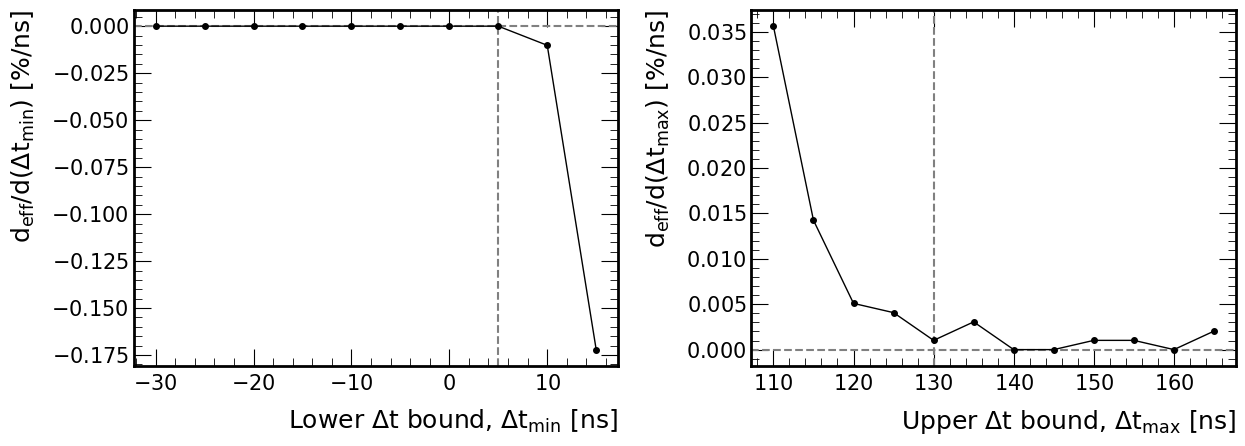

In [165]:
# Scan 1: Vary dt_min (fix dt_max)
dt_max_fixed = 150
slice_lower = df_scan[df_scan['dt_max'] == dt_max_fixed].sort_values('dt_min').copy()
slice_lower['deff_ddt_min'] = slice_lower['eff_cry'].diff() / slice_lower['dt_min'].diff()

# Scan 2: Vary dt_max (fix dt_min)
dt_min_fixed = -25
slice_upper = df_scan[df_scan['dt_min'] == dt_min_fixed].sort_values('dt_max').copy()
slice_upper['deff_ddt_max'] = slice_upper['eff_cry'].diff() / slice_upper['dt_max'].diff()

fig, ax = plt.subplots(1, 2, figsize=(6.4*2, 4.8))

plotter.plot_graph(
    x=slice_lower["dt_min"],
    y=slice_lower["deff_ddt_min"],
    linestyle="-",
    xlabel=r"Lower $\Delta t$ bound, $\Delta t_{\text{min}}$ [ns]",
    ylabel=r"$d_{\text{eff}}/d(\Delta t_{\text{min}})$ [%/ns]",
    show=False,
    col="black",
    ax=ax[0]
)

plotter.plot_graph(
    x=slice_upper["dt_max"],
    y=slice_upper["deff_ddt_max"],
    linestyle="-",
    xlabel=r"Upper $\Delta t$ bound, $\Delta t_{\text{max}}$ [ns]",
    ylabel=r"$d_{\text{eff}}/d(\Delta t_{\text{max}})$ [%/ns]",
    ax=ax[1],
    col="black",
    show=False
)

ax[0].axhline(0, ls='--', color='grey')
ax[1].axhline(0, ls='--', color='grey')

ax[0].axvline(5, ls='--', color='grey')
ax[1].axvline(130, ls='--', color='grey')

plt.tight_layout()

out_name = img_base_path / "gr_1x2_dt_eff_bounds.png" 
plt.savefig(out_name, dpi=300)
print(f"\tWrote {out_name}")
plt.show()

	Wrote ../../output/images/dt/paper/h2_1x2_dt_eff_deadtime.png


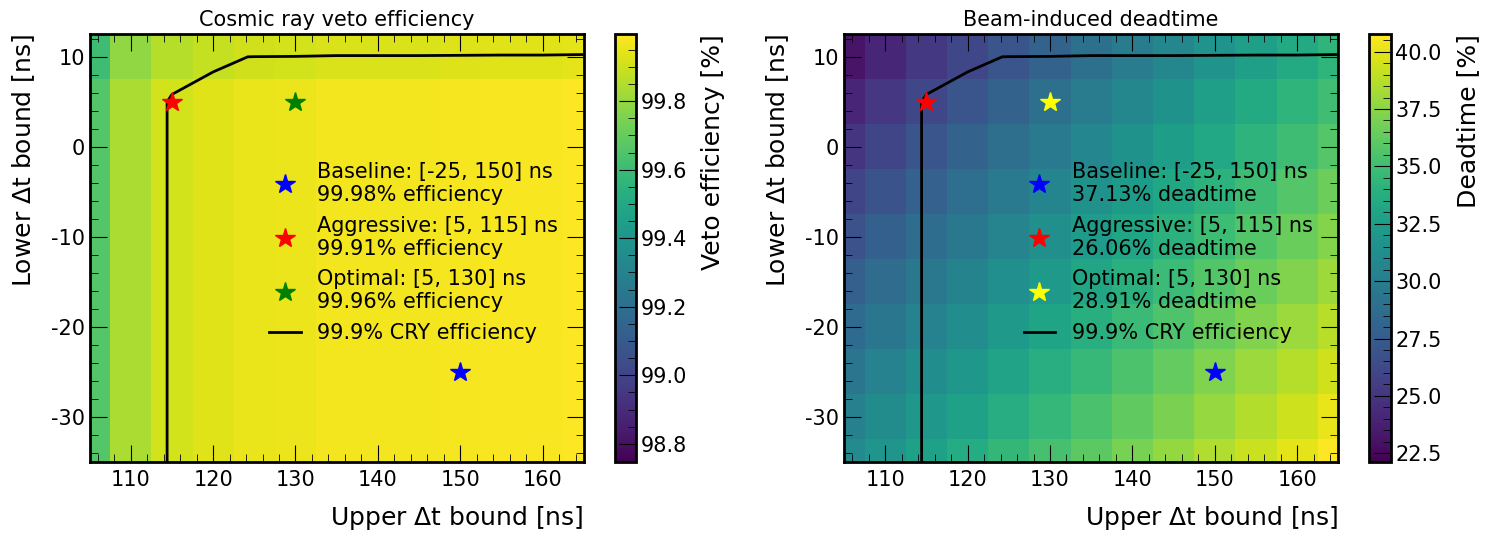

In [166]:
fig, ax = plt.subplots(1, 2, figsize=(1.2*6.4*2, 1.2*4.8))

# Get the new optimal point data
optimal_new = df_scan[(df_scan['dt_min'] == 5) & (df_scan['dt_max'] == 130)].iloc[0]
aggressive = optimal  # Rename old optimal to aggressive

# CRY veto efficiency
pivot_cry = df_scan.pivot(index='dt_min', columns='dt_max', values='eff_cry')
im1 = ax[0].pcolormesh(pivot_cry.columns, pivot_cry.index, pivot_cry.values, cmap='viridis')
contour_cry = ax[0].contour(pivot_cry.columns, pivot_cry.index, pivot_cry.values, levels=[99.9], colors='black', linewidths=2)
ax[0].set_xlabel(r'Upper $\Delta t$ bound [ns]')
ax[0].set_ylabel(r'Lower $\Delta t$ bound [ns]')
ax[0].set_title('Cosmic ray veto efficiency')
cbar1 = plt.colorbar(im1, ax=ax[0])
cbar1.set_label('Veto efficiency [%]')
ax[0].plot(150, -25, marker='*', color="blue", markersize=15, linestyle='none', label=f'Baseline: [-25, 150] ns\n{baseline["eff_cry"]:.2f}% efficiency')
ax[0].plot(aggressive['dt_max'], aggressive['dt_min'], marker='*', color='red', markersize=15, linestyle='none', label=f'Aggressive: [{aggressive["dt_min"]:.0f}, {aggressive["dt_max"]:.0f}] ns\n{aggressive["eff_cry"]:.2f}% efficiency')
ax[0].plot(130, 5, marker='*', color='green', markersize=15, linestyle='none', label=f'Optimal: [5, 130] ns\n{optimal_new["eff_cry"]:.2f}% efficiency')
ax[0].plot([], [], 'k-', linewidth=2, label='99.9% CRY efficiency')
ax[0].legend(loc="best")

# CE Mix2BB deadtime
pivot_mix = df_scan.pivot(index='dt_min', columns='dt_max', values='eff_mix')
im2 = ax[1].pcolormesh(pivot_mix.columns, pivot_mix.index, pivot_mix.values, cmap='viridis')
contour_mix = ax[1].contour(pivot_cry.columns, pivot_cry.index, pivot_cry.values, levels=[99.9], colors='black', linewidths=2)
ax[1].set_xlabel(r'Upper $\Delta t$ bound [ns]')
ax[1].set_ylabel(r'Lower $\Delta t$ bound [ns]')
ax[1].set_title('Beam-induced deadtime')
cbar2 = plt.colorbar(im2, ax=ax[1])
cbar2.set_label('Deadtime [%]')
ax[1].plot(150, -25, marker='*', color="blue", markersize=15, linestyle='none', label=f'Baseline: [-25, 150] ns\n{baseline["eff_mix"]:.2f}% deadtime')
ax[1].plot(aggressive['dt_max'], aggressive['dt_min'], marker='*', color='red', markersize=15, linestyle='none', label=f'Aggressive: [{aggressive["dt_min"]:.0f}, {aggressive["dt_max"]:.0f}] ns\n{aggressive["eff_mix"]:.2f}% deadtime')
ax[1].plot(130, 5, marker='*', color='yellow', markersize=15, linestyle='none', label=f'Optimal: [5, 130] ns\n{optimal_new["eff_mix"]:.2f}% deadtime')
ax[1].plot([], [], 'k-', linewidth=2, label='99.9% CRY efficiency')
ax[1].legend(loc="best")

# Set ranges 
ax[0].set_xlim(105, 165)
ax[1].set_xlim(105, 165)
ax[0].set_ylim(-35, 12.5)
ax[1].set_ylim(-35, 12.5)

# Move legend down a bit
ax[0].legend(loc="upper right", bbox_to_anchor=(0.99, 0.75))
ax[1].legend(loc="upper right", bbox_to_anchor=(0.99, 0.75))

plt.tight_layout()

out_name = img_base_path / "h2_1x2_dt_eff_deadtime.png" 
plt.savefig(out_name, dpi=300)
print(f"\tWrote {out_name}")
plt.show()

Wrote: ../../output/images/dt/paper/h1_dT_prob_opt_bounds.png


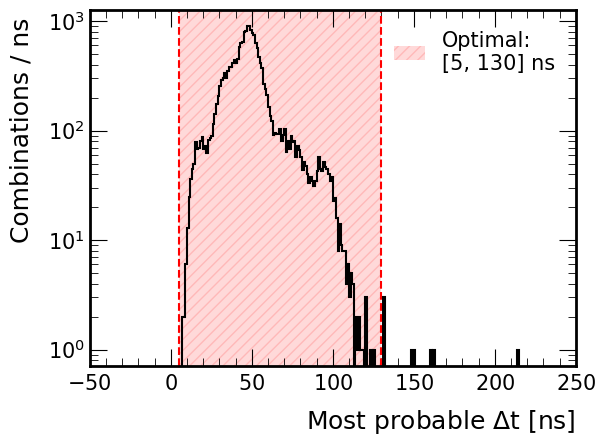

In [192]:
fig, ax = plt.subplots()

plotter.plot_1D(
    dt_prob,
    nbins=300,
    xmin=-50,
    xmax=250,
    xlabel=r"Most probable $\Delta t$ [ns]",
    ylabel="Combinations / ns ",
    ax=ax,
    show=False,
    log_y=True,
    stat_box=False
)

# Shaded hatched region
ax.axvspan(5, 130, alpha=0.15, color='red', hatch='///', edgecolor='red', 
           linewidth=0, label='Optimal:\n[5, 130] ns')

# Vertical lines at boundaries
ax.axvline(5, color='red', linestyle='--', linewidth=1.5)
ax.axvline(130, color='red', linestyle='--', linewidth=1.5)

ax.legend()
plt.tight_layout()
out_path = img_base_path / "h1_dT_prob_opt_bounds.png"
plt.savefig(out_path, dpi=300)
print(f"Wrote: {out_path}")